In [10]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
from pandas import Series, DataFrame
import random

#시각화 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.formula.api as smf
import statsmodels.api as sm

#소수점 3자리까지 표시
%precision 3

'%.3f'

## 1) 순열검정 알고리즘 구현

In [11]:
#데이터 불러오기
d_data = pd.read_csv('2020.csv', encoding='cp949').iloc[:,0:13]
data = d_data.iloc[:,2:]

In [12]:
# 행복지수가 평균 이상인 그룹 (case)와 평균 미만인 그룹(normal)로 나눠주기
case = data[data['Ladder_score'] >= data['Ladder_score'].mean()]
normal = data[data['Ladder_score'] < data['Ladder_score'].mean()]

In [13]:
#case그룹과 normal그룹의 1인당 GDP 평균차이
print(case['Logged_GDP_per_capita'].mean()-normal['Logged_GDP_per_capita'].mean())

1.633989128967123


- 가설 : 행복지수가 평균 이상인 그룹(A)에서는 평균미만인 그룹(B)보다 1인당 GDP가 더 높게 나올 것이다
- 귀무가설 : A = B
- 대립가설 : A != B 

## 2) 순열검정 10,000회 반복하기

(array([ 13.,  33., 121., 169., 228., 195., 118.,  86.,  33.,   4.]),
 array([-0.53 , -0.421, -0.312, -0.203, -0.094,  0.016,  0.125,  0.234,
         0.343,  0.452,  0.562]),
 <a list of 10 Patch objects>)

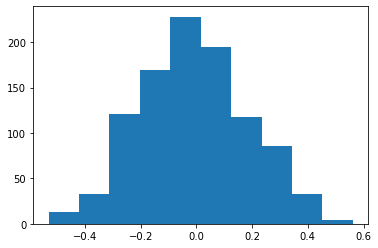

In [17]:
# 순열검정 수행
# case그룹과 normal그룹의 1인당 GDP 평균 차이 구하기
result = []
R = 1000
A = [x for x in case['Logged_GDP_per_capita']]
B = [x for x in normal['Logged_GDP_per_capita']]
C = A+B

# 자료를 랜덤하게 섞어준 후 추출
for _ in range(R):
    random.shuffle(C) 
    new_A = C[:81]
    new_B = C[81:]
    result.append(sum(new_A)/len(new_A) - sum(new_B)/len(new_B))
    
#그룹간 비교 통계량 분포    
plt.hist(result)

In [18]:
k = sum(A)/len(A) - sum(B)/len(B) # 실제 데이터에서 평균 차이
print(k)

1.633989128967123


In [19]:
k_result = [x for x in result if x > k or x < -k] # 양측검정
len(k_result)* 100/len(result) # p-value

0.000

- p-value = 0
- 관측한 차이는 k = 약 1.634로 순열로 보이는 차이의 집합안에 들어가 있지 않다. 따라서 이 결과는 우연히 일어날 수 있는 범위 밖에 있으므로 우연때문에 나타난 결과가 아니다.
- 이 데이터에 대한 결과는 통계적으로 유의미하다.

## 3)t-test를 이용해 위의 그룹간 평균 차이를 비교

- independent t-test와 paired t-test 중 independent t-test가 적합
- 행복지수로 인한 1인당 GDP의 변화를 관측하는 것이 아니라 1인당 GDP의 평균값을 관측하는 것이기 때문

In [21]:
z, t = stats.ttest_ind(A,B)
print(t) # p-value

3.193889688271856e-22


- 거의 0에 가까운 수로 permutation test에서의 p-value(0.000)와 차이가 적음

## 4)  범주형 변수 간의 조합에 대해 교차표

In [22]:
data['Up_Ladder'] = np.where(data['Ladder_score']>= data['Ladder_score'].mean(),1,0)
data['Up_GDP'] = np.where(data['Logged_GDP_per_capita']>= data['Logged_GDP_per_capita'].mean(),1,0)
per = pd.crosstab(index = data.Up_GDP, columns = data.Up_Ladder, margins = True)
per

Up_Ladder,0,1,All
Up_GDP,,,
0,52,14,66
1,21,66,87
All,73,80,153


- 행복지수가 평균이상일 때 1인당GDP도 평균이상일 전체 확률: 87/153 = 56.86%  

## 5) ) chi-sqaure 통계량 혹은 resampling 방법을 사용해서 4)의 교차표에 chi-square test를 진행하고 p값을 계산

In [24]:
chisq, pvalue,df,expected = stats.chi2_contingency(per) # chi-sqaure 통계량 사용
pvalue # p-value

4.114534799148059e-09